## Imports 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

ERROR: Could not find a version that satisfies the requirement System.IO (from versions: none)
ERROR: No matching distribution found for System.IO


In [ ]:
import os
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from pathlib import Path
import cv2
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
#path_img = Path('images')
#fnames = os.listdir(str(path_img))
#path_lbl = Path('masks')
#lblnames = os.listdir(str(path_lbl))
#fnames.sort()
#lblnames.sort()

## Importing inputs

In [ ]:
path_lbl = Path(Path.home()/'/content/drive/My Drive/DL/Images For Fast.AI/Sentinal 2 Masks/Sentinal 2 Masks for Fast AI')
path_img = Path(Path.home()/'/content/drive/My Drive/DL/Masks for Fast.AI/Sentinal 2 im/Sentinal 2 Images for Fast AI')
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

In [ ]:
# Converting to png
#for k in range(0,len(fnames)):
#    ds = pydicom.dcmread(os.path.join(str(path_img),fnames[k]))
#    I = ds.pixel_array/np.amax(ds.pixel_array)*255
#    I = I.astype('uint8')
#    im = Image.fromarray(I)
#    filename = os.path.splitext(fnames[k])[0]
#    im.save(os.path.join('Train_Sets_png', filename + '.png')) 

In [ ]:
# Renaming masks
#for k in range(0,len(lblnames)):
#    I = Image.open(os.path.join(str(path_lbl),lblnames[-1]))
#    filename = os.path.splitext(fnames[-1])[0]
#    I.save(os.path.join('Train_Sets_masks', filename + '.png')) 

In [ ]:
# #Real Preprocessing ( **PLEASE RUN ONLY ONCE** )
# for i in range(0, len(lbl_names)):   
#    img = cv2.imread(str(lbl_names[i]), 0)
#    new_img = img / 255.0
#    new_img = Image.fromarray((new_img).astype(np.uint8))
#    #plt.imshow(new_img, cmap = 'gray', interpolation = 'bicubic')
#    #plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
#    #plt.show()
#    new_img.save(str(lbl_names[i]))

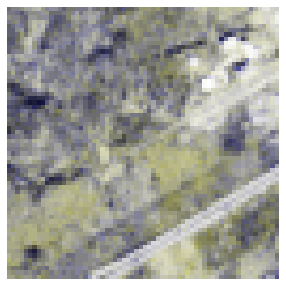

In [ ]:
img_f = fnames[500]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

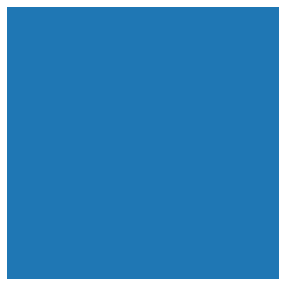

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([64, 64]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [ ]:
codes = np.loadtxt(Path(Path.home()/'/content/drive/My Drive/DL/Codes.txt'), dtype=str); codes

array(['Structured', 'Unstructured'], dtype='<U12')

## Creating ImageDataBunch

In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=2
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=2, have 11430MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(0.15)
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

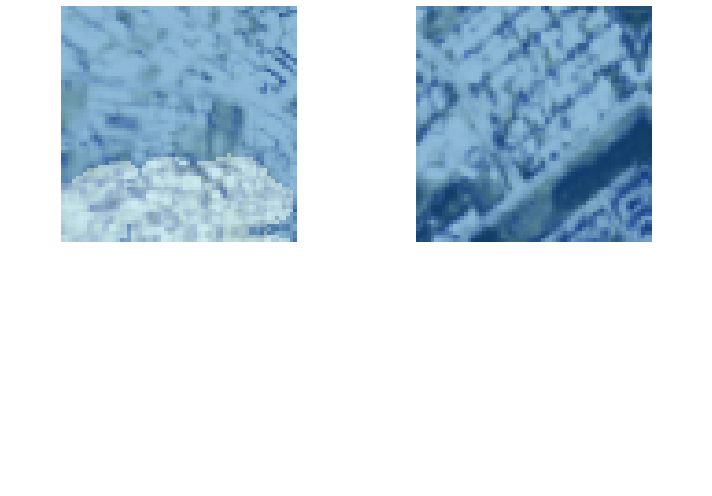

In [ ]:
data.show_batch(2, figsize=(10,7))

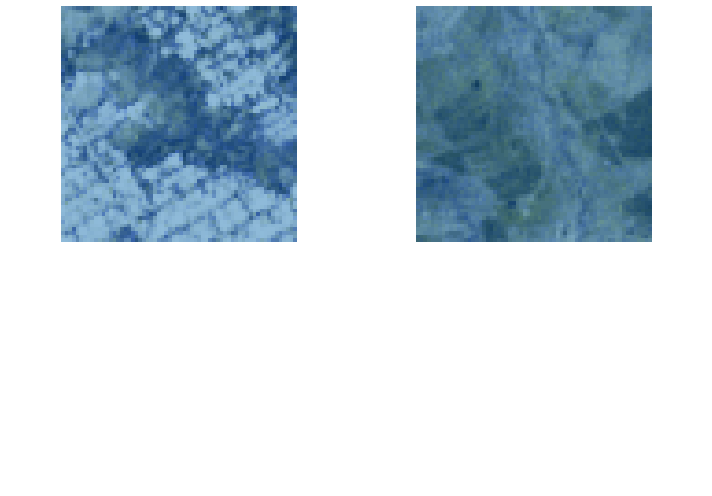

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id['Structured']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

{'Structured': 0, 'Unstructured': 1}


In [ ]:
metrics=acc_camvid
# metrics=accuracy

## Creating Unet Learner Object

In [ ]:
wd=1e-2 #weight decay

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=[dice,acc_camvid], wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,dice,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


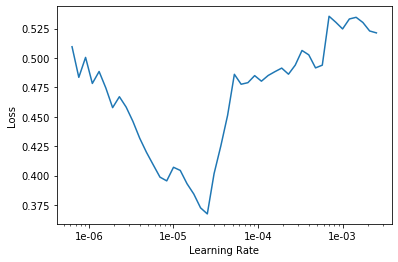

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=8e-5

In [ ]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice,acc_camvid,time
0,0.224938,0.185896,0.615835,nan,01:17
1,0.172092,0.153548,0.739047,nan,01:16
2,0.220317,0.241246,0.538338,nan,01:16
3,0.222079,0.161467,0.722928,nan,01:16
4,0.161084,0.137584,0.750919,nan,01:15


In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

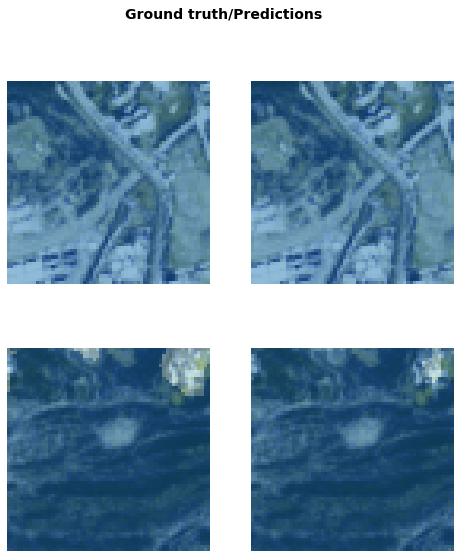

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4) # learning rate slicing

In [ ]:
learn.fit_one_cycle(35, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice,acc_camvid,time
0,0.126375,0.152230,0.732910,nan,01:15
1,0.119574,0.149930,0.749304,nan,01:15
2,0.139470,0.146257,0.740641,nan,01:15
3,0.137757,0.132670,0.758468,nan,01:16
4,0.133175,0.132125,0.770006,nan,01:15
5,0.140851,0.130075,0.775515,nan,01:16
6,0.129473,0.127309,0.768712,nan,01:15
7,0.135762,0.141639,0.756347,nan,01:16
8,0.131053,0.143942,0.765990,nan,01:15
9,0.133501,0.122201,0.771576,nan,01:16


In [ ]:
learn.save('stage-2');

In [ ]:
learn.load('stage-2')
#learn.show_results(rows=5, figsize=(8,9))

Learner(data=ImageDataBunch;

Train: LabelList (1439 items)
x: SegmentationItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: SegmentationLabelList
ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64)
Path: /content/drive/My Drive/DL/Masks for Fast.AI/Sentinal 2 im/Sentinal 2 Images for Fast AI;

Valid: LabelList (253 items)
x: SegmentationItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: SegmentationLabelList
ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64)
Path: /content/drive/My Drive/DL/Masks for Fast.AI/Sentinal 2 im/Sentinal 2 Images for Fast AI;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64

## Predictions on Validation Set

/content


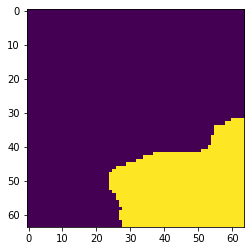

In [ ]:
names_valid = data.valid_ds.items
for i in range(0, len(names_valid)):
    p = learn.predict(data.valid_ds.x[i])
    p[0].save('Output_predictions' + names_valid[i].stem + '.png')
    


# img = mpimg.imread('Output_predictions43.png')
# plt.imshow(img)
# plt.show()



## Saving Final Model

In [ ]:
learn.export()

In [ ]:
learn.show_results(ds_type=DatasetType.Train)

TypeError: ignored